# Fairness Analysis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

## Load Data and Preprocessing
Necessary preprocessing, can be also seen in first notebook

In [4]:
# Keep only needed columns
feature_names = [
    "Age", "Workclass", "Education", 
    "Occupation", "Relationship", "Race", 
    "Sex", "Capital Gain", "Capital Loss", 
    "Hours per week", "Country", "label"
]

df = pd.DataFrame(
  np.genfromtxt('dataset/adult.csv', delimiter=', ', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)

# Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()


# Declare categorical columns
categorical_columns=[
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country", "label"
]

# Assign type to features
for feature in feature_names:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

# Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35 , 90],labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
            x=df["Hours per week"],
            bins=[0.9, 25, 39, 40, 55, 100],
            labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"])

# Replace "Husband" and "Wife" values with the unisex "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

# Will have income >50k (1 or 0)
df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)
df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
28197,Aged,Private,Prof-school,Prof-specialty,Married,White,Male,15024,0,OverTime,Germany,1
21784,Young,Private,HS-grad,Farming-fishing,Own-child,White,Male,0,0,FullTime,United-States,0
9996,Young,Private,HS-grad,Other-service,Own-child,White,Female,0,0,PartTime,United-States,0
29454,Young,Private,Some-college,Craft-repair,Married,White,Male,0,0,OverTime,United-States,1
29302,Aged,Local-gov,Some-college,Exec-managerial,Not-in-family,White,Male,0,0,FullTime,United-States,0


Visualizing the imbalanceness:

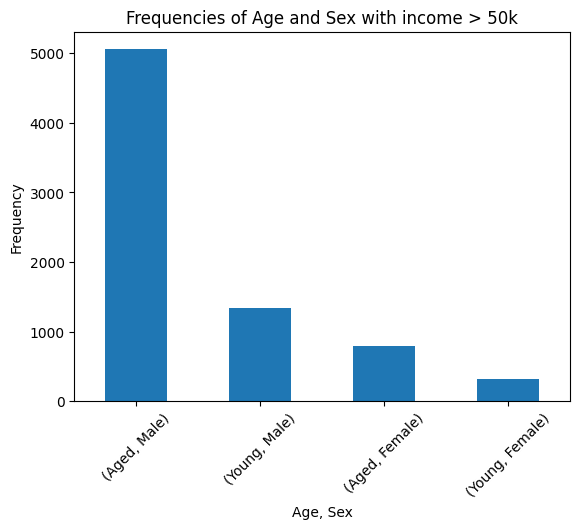

In [6]:
count_data = df[df.label == 1][['Age', 'Sex']].value_counts()
# Create a bar plot
count_data.plot(kind='bar')
plt.title('Frequencies of Age and Sex with income > 50k')
plt.xlabel('Age, Sex')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Model Creation

In [8]:
# Data preprocessing to train model
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tabular_data = Tabular(
   df,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

## Fairness
Now the fairness will be analyzed

First we import the necessary libraries

In [10]:
import sys
import os
# setting path to import common_utils file found inside utils folder
sys.path.append(os.path.abspath('./utils'))

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
import random
from aif360.metrics import ClassificationMetric
from tqdm import tqdm
from common_utils import compute_metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Since for the fairness analysis, we can not use the Tabular data, we create a new dataframe with the transformed values of TabularTransform. This is because we need to have access to a dataframe structure containing the binarized values (for age, sex and all categorical attributes) and not the categorical values (e.g. Young/Aged, Female/Male etc.)

In [12]:
column_names = transformer.get_feature_names()
# Last column is the label which is not included in the get_feature_names
column_names.append('label')

fairness_dataset = pd.DataFrame(x, columns=column_names)
fairness_dataset.head(3)

,Age_Aged,Age_Young,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,...,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Capital Gain,Capital Loss,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2174.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


As seen below there are four columns for the protected attributes of sex and age. Two boolean columns for each:

In [14]:
fairness_dataset[['Age_Aged', 'Age_Young', 'Sex_Male', 'Sex_Female']].head(3)

,Age_Aged,Age_Young,Sex_Male,Sex_Female
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0


We decide only to keep `Age_Aged` and `Sex_Male`, and renaming those to columns to `Age` and `Sex` meaning that:
- when `Sex` is 0, the person is female and when when `Sex` is 1, the person is male
- when `Age` is 0, the person is young and  when `Age` is 0, the person is aged


In [16]:
fairness_dataset = fairness_dataset.drop(columns=['Age_Young', 'Sex_Female'])
fairness_dataset.rename(columns={'Age_Aged': 'Age', 'Sex_Male': 'Sex'}, inplace=True)
fairness_dataset.head(3)

,Age,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,Education_11th,...,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Capital Gain,Capital Loss,label
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2174.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Next we want to ensure that we train the classifier on the exact same data as the previous normal classifier, keeping the train, validation and test split:

In [18]:
# Split data into training and (validation + test) datasets
train, X_temp, _, y_temp  = \
    train_test_split(fairness_dataset, fairness_dataset.label, train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, _, _ = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

Now we can transform into BinaryLabelDatasets:

In [20]:
# Transform to BinaryLabelDataset
dataset_fair_train = BinaryLabelDataset(df=train, label_names=['label'], protected_attribute_names=['Age', 'Sex'])
dataset_fair_valid = BinaryLabelDataset(df=val, label_names=['label'], protected_attribute_names=['Age', 'Sex'])
dataset_fair_test = BinaryLabelDataset(df=test, label_names=['label'], protected_attribute_names=['Age', 'Sex'])

We only need to work with the training data in order to compute the fairness metric

Now the group fairness of the classifier will be assessed, assuming the protected attributes are Age, Sex.

We assume that:
- Young age (corresponding to 0) is one unprivileged group and Aged (corresponding to 1) is one privileged group
- Female sex is one unprivileged (corresponding to 0) group and male sex (corresponding to 1) is one privileged group:

In [23]:
privileged_groups = [{'Age':1,
                      'Sex':1}]
unprivileged_groups = [{'Age': 0,
                       'Sex':0}]

Now, we compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter. A negative value indicates less favorable outcomes for the unprivileged groups. This measures the difference in <b> statistical parity </b>, in other words comparing the positive rates of favorable outcome (be predicted as $>50k$ income) of the privileged and unprivileged groups:

In [25]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_fair_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.368967


#### <u> Insight </u> 
There is a significant difference in the positive rates and thus there is unfairness. Actually, the priviliged groups (aged and male) has 37% more chance to be predicted as >50k income comparing to the unprivileged group (young, female)

Now, we will try to mitigate this bias in the training dataset by using the `Reweighing algorithm`. By reweighing we ensure that there is better fairness when we compare the positive rates between privileged and unprivileged groups

In [28]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_fair_train)

Now let's see the metric of statistical parity again:

In [30]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,

                                               privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Train & evaluate classifier on original data

In [32]:
X_train = dataset_fair_train.features
y_train = dataset_fair_train.labels.ravel()

# Train a Random Forest model
model_fair = RandomForestClassifier(random_state=123)
model_fair.fit(X_train, y_train)
y_train_pred = model_fair.predict(X_train)

# positive class index
pos_ind = np.where(model_fair.classes_ == dataset_fair_train.favorable_label)[0][0]

dataset_fair_train_pred = dataset_fair_train.copy()
dataset_fair_train_pred.labels = y_train_pred

In [33]:
dataset_fair_valid_pred = dataset_fair_valid.copy(deepcopy=True)
X_valid = dataset_fair_valid.features
y_valid = dataset_fair_valid.labels
dataset_fair_valid_pred.scores = model_fair.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_fair_valid_pred.scores[:5])

dataset_fair_test_pred = dataset_fair_test.copy(deepcopy=True)
X_test = dataset_fair_test_pred.features
y_test = dataset_fair_test_pred.labels
dataset_fair_test_pred.scores = model_fair.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.33766667]
 [0.14015859]
 [0.48430521]
 [0.015     ]
 [0.        ]]


Finding the optimal classification threshold from the validation set to maximize accuracy:

In [35]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_fair_valid_pred.scores > class_thresh
    dataset_fair_valid_pred.labels[fav_inds] = dataset_fair_valid_pred.favorable_label
    dataset_fair_valid_pred.labels[~fav_inds] = dataset_fair_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_fair_valid,
                                             dataset_fair_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    # Metric we wish to maximize
    ba_arr[idx] = classified_metric_orig_valid.accuracy()

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best Normal accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best Normal accuracy (no reweighing) = 0.8550
Optimal classification threshold (no reweighing) = 0.5049


Next let's check the metrics of the original classifier:

Test: accuracy=0.8482
Test: TP=722, TN=3116, FP=265, FN=422


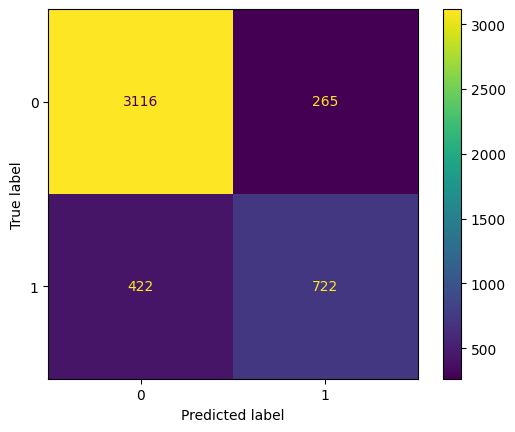

In [37]:
predictions = model_fair.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(y_test, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

Looks like due to dropping the attributes of `age_young` and `sex_female`, we lose some accuracy of $0.003$ even though there was no change of the data or random_state and the attributes age `young` and `aged` and sex `male` and `female` are basically opposite boolean values. This is probably due to the model of random_forest since it involves some randomness in selecting subsets of features (columns) to split on at each node of the decision trees. With two attributes removed the whole selection process is different.

Also, the fairness metrics:

In [39]:
fav_inds = dataset_fair_test_pred.scores > 0.5
dataset_fair_test_pred.labels[fav_inds] = dataset_fair_test_pred.favorable_label
dataset_fair_test_pred.labels[~fav_inds] = dataset_fair_test_pred.unfavorable_label

print('Metrics of original classifier')
metric_test_bef = compute_metrics(dataset_fair_test, dataset_fair_test_pred, 
                                  unprivileged_groups, privileged_groups,
                                  disp = True)

Metrics of original classifier
Balanced accuracy = 0.7764
Normal accuracy = 0.8482
Statistical parity difference = -0.3575
Disparate impact = 0.1107
Average odds difference = -0.1994
Equal opportunity difference = -0.2390
Theil index = 0.1194


Predictions from the original test set at the optimal classification threshold:

In [41]:
print("Predictions from original testing data")
eq_op_dif_orig = []
bal_acc_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_fair_test_pred.scores > thresh
    dataset_fair_test_pred.labels[fav_inds] = dataset_fair_test_pred.favorable_label
    dataset_fair_test_pred.labels[~fav_inds] = dataset_fair_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_fair_test, dataset_fair_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    eq_op_dif_orig.append(metric_test_bef["Equal opportunity difference"])
    bal_acc_arr_orig.append(metric_test_bef["Normal accuracy"])

Predictions from original testing data
Classification threshold used = 0.5049


 73%|██████████████████████████████████████████████████████████▍                     | 73/100 [00:00<00:00, 238.02it/s]

Balanced accuracy = 0.7739
Normal accuracy = 0.8480
Statistical parity difference = -0.3496
Disparate impact = 0.1129
Average odds difference = -0.1913
Equal opportunity difference = -0.2299
Theil index = 0.1209


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 247.77it/s]


Display results for all thresholds:

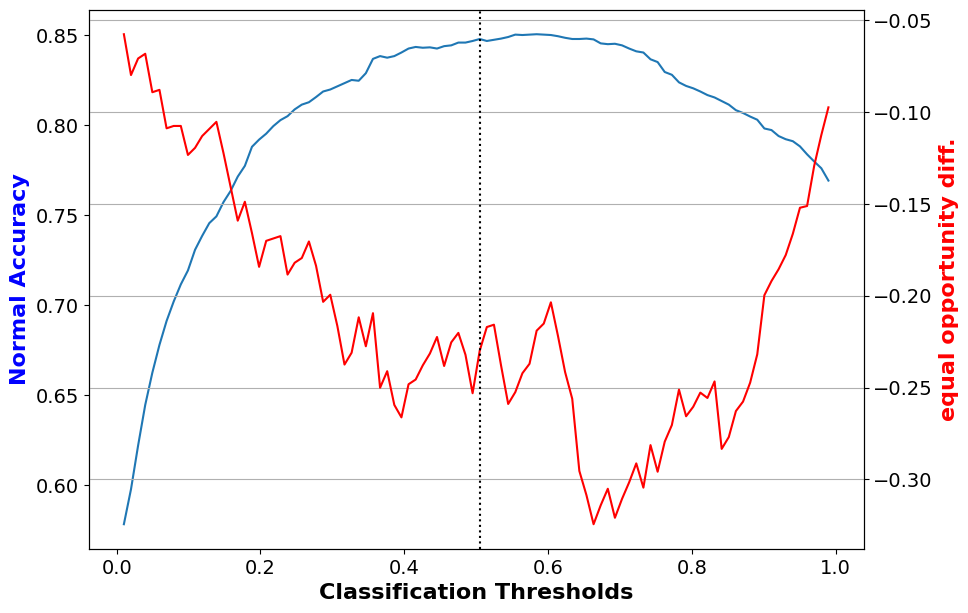

In [43]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Normal Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, eq_op_dif_orig, color='r')
ax2.set_ylabel('equal opportunity diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Fair classifier

Since reweighting does not achieve the goal of 0 statistical parity difference, we will oversample the underprivileged classes (female young) and undersample the privileged classes (male aged) to teach the classifier to be more fair. After some experimentation, it was decided:
- $750$ extra samples of young female with income >50k were randomly oversampled, and random weights of values between $[1.2,1.6]$ were given for each sample
- $1500$ samples of aged male with income >50k were randomly undersampled (completely removed from the training set)

In [45]:
# Seed to reproduce results
random.seed(1)

# Number of extra samples produced for training dataset
number_oversamples = 750
number_undersamples = 1500

# Train and target data
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

# Resampled data structures
X_train_resampled = X_train.copy()
y_train_resampled = y_train.copy()
weights_resampled = dataset_transf_train.instance_weights.copy()

# list to keep for indexes of undersamples (to be deleted)
list_indexes_undersamples = []
# List to keep the extra_samples and counters
oversamples = []
counter_oversamples = 0
counter_undersamples = 0

# Iterate over the whole training dataset
for counter in range(len(X_train)):
    # Only append rows that contain young female since this is the heavily underprivileged class
    if (X_train[counter][0] == 0) and (X_train[counter][1] == 0) and (y_train[counter] == 1)\
        and (counter_oversamples < number_oversamples):
        oversamples.append(X_train[counter].copy())
        counter_oversamples += 1
    # Save index of rows that contain aged male since this is the heavily overpriviliged class
    if ((X_train[counter][0] == 1) or (X_train[counter][1] == 1)) and (y_train[counter] == 1)\
        and (counter_undersamples < number_undersamples):
        list_indexes_undersamples.append(counter)
        counter_undersamples += 1
    # When number of extra oversamples and undersamples is reached, stop loop
    if (counter_oversamples == number_oversamples) and (counter_undersamples == number_undersamples):
        break
    counter += 1

# Remove all indexes of undersamples
X_train_resampled = np.delete(X_train_resampled, list_indexes_undersamples, axis=0)
y_train_resampled = np.delete(y_train_resampled, list_indexes_undersamples)
weights_resampled = np.delete(weights_resampled, list_indexes_undersamples)


# Only assign positive labels to favor underprivileged class 
arr = np.array([1 for i in range(number_oversamples)])

# Append extra samples and labels to the training data and 
y_train_resampled = np.append(y_train_resampled, arr)
X_train_resampled = np.vstack([X_train_resampled, oversamples])
# Randomize weights of extra samples to take values between 1 and 1.5
weights_resampled = np.append(weights_resampled, np.array([random.uniform(1.2, 1.6) for i in range(number_oversamples)]))

Now we can train the classifier:

In [47]:
model_fair_reweighted = RandomForestClassifier(random_state=123)
model_fair_reweighted.fit(X_train_resampled, y_train_resampled, sample_weight=weights_resampled)
y_train_pred = model_fair_reweighted.predict(X_train_resampled)

Obtain scores for transformed test set

In [49]:
dataset_transf_test_pred = dataset_fair_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = model_fair_reweighted.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

Finding the optimal classification threshold from the validation set for the fairness classifier:

In [51]:
dataset_fair_valid_pred = dataset_fair_valid.copy(deepcopy=True)
X_valid = dataset_fair_valid.features
y_valid = dataset_fair_valid.labels
dataset_fair_valid_pred.scores = model_fair_reweighted.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)


num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_fair_valid_pred.scores > class_thresh
    dataset_fair_valid_pred.labels[fav_inds] = dataset_fair_valid_pred.favorable_label
    dataset_fair_valid_pred.labels[~fav_inds] = dataset_fair_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_fair_valid,
                                             dataset_fair_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    # Metric we wish to maximize
    ba_arr[idx] = classified_metric_orig_valid.accuracy()
    #ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate() + classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best Normal accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best Normal accuracy (no reweighing) = 0.8373
Optimal classification threshold (no reweighing) = 0.4555


Now we can calculate the metrics:

In [53]:
print(" Predictions from transformed testing data")
bal_acc_arr_transf = []
eq_opp_diff_tranf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_fair_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Normal accuracy"])
    eq_opp_diff_tranf.append(metric_test_aft["Equal opportunity difference"])

 Predictions from transformed testing data
Classification threshold used = 0.4555


 71%|████████████████████████████████████████████████████████▊                       | 71/100 [00:00<00:00, 178.94it/s]

Balanced accuracy = 0.7382
Normal accuracy = 0.8296
Statistical parity difference = -0.1918
Disparate impact = 0.3270
Average odds difference = -0.0014
Equal opportunity difference = 0.0202
Theil index = 0.1414


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 194.14it/s]


#### <u> Insight </u> 
By following the described steps of fairness we managed to achieve Equal Opportunity Fairness, which ensures that true positive rates (TPR) are the same across different protected groups, meaning sex and age. In detail, the classifier ensures that the underprivileged groups aren't unfairly denied positive outcomes simply due to their group membership (young age and female sex)

And the graph of equal opportunity difference:

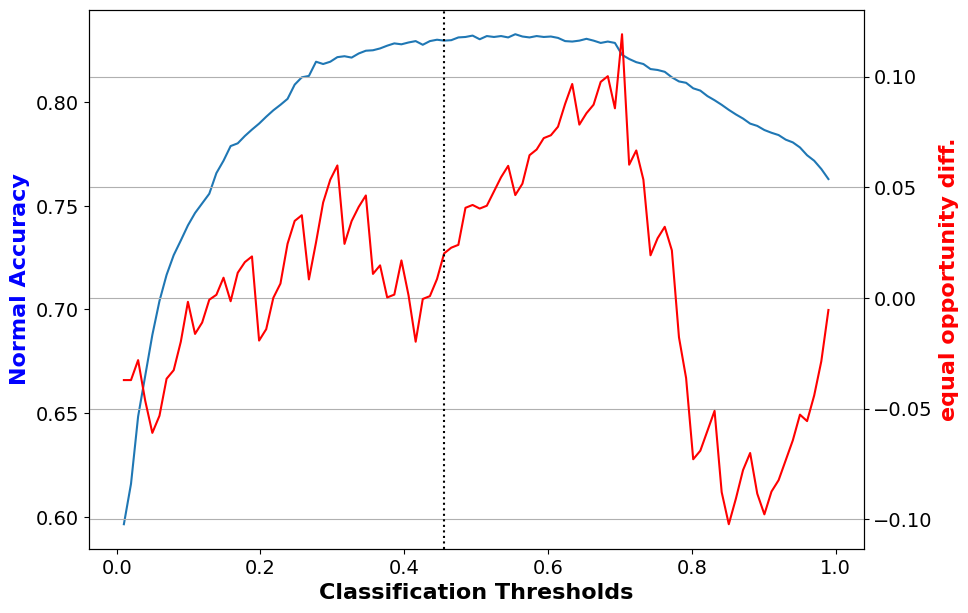

In [56]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Normal Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, eq_opp_diff_tranf, color='r')
ax2.set_ylabel('equal opportunity diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

Now we can calculate the predictions based on the found threshold:

In [58]:
X_test = dataset_fair_test.features
y_test = dataset_fair_test.labels

predictions = []
threshold_fairness = best_class_thresh
# positive class index
pos_ind = np.where(model_fair_reweighted.classes_ == dataset_fair_train.favorable_label)[0][0]

for item in model_fair_reweighted.predict_proba(X_test)[:,pos_ind].reshape(-1,1):
    if item >=  threshold_fairness:
        predictions.append(1)
    else:
        predictions.append(0)

Print the metrics:

Test: accuracy=0.8296
Test: TP=633, TN=3121, FP=260, FN=511


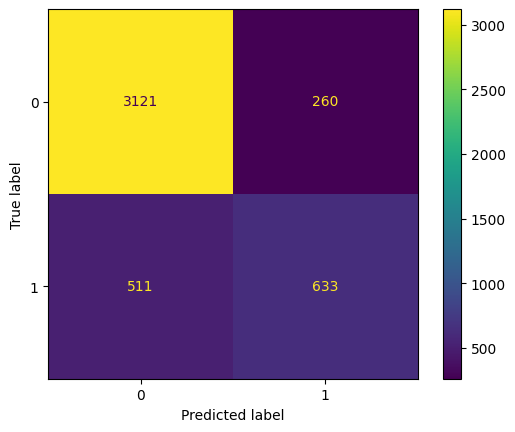

In [60]:
accuracy = accuracy_score(y_test, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(y_test, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

## Free Exploration
In this chapter we will try to achieve a `statistical parity` of $0$

Interestingly enough, this can be achieved by reweighting and oversampling the underprivileged group with a negative label while altering their target label to positive. Essentially, this involves introducing new samples to the model with intentionally incorrect target labels. The goal is to train the model to reduce bias, as statistical parity measures the positive prediction rates (e.g., predicted income levels) between privileged and underprivileged groups

In [62]:
# Seed to reproduce results
random.seed(1)

# Number of extra samples produced for training dataset
number_oversamples = 2200

# Train and target data
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

# Resampled data structures
X_train_resampled = X_train.copy()
y_train_resampled = y_train.copy()
weights_resampled = dataset_transf_train.instance_weights.copy()

# List to keep the extra_samples and counters
oversamples = []
counter_oversamples = 0

# Iterate over the whole training dataset
for counter in range(len(X_train)):
    # Only append rows that contain young female since this is the heavily underprivileged class 
    # Randomize selection in order to have more variety among all the rows of the training set
    if (X_train[counter][0] == 0) and (X_train[counter][1] == 0) and (y_train[counter] == 0)\
        and (counter_oversamples < number_oversamples) and random.random() < 0.65:
        oversamples.append(X_train[counter].copy())
        counter_oversamples += 1
    # When number of extra oversamples is reached, stop loop
    if (counter_oversamples == number_oversamples):
        break
    counter += 1

# Only assign positive labels to favor underprivileged class 
arr = np.array([1 for i in range(number_oversamples)])

# Append extra samples and labels to the training data and 
y_train_resampled = np.append(y_train_resampled, arr)
X_train_resampled = np.vstack([X_train_resampled, oversamples])
# Randomize weights of extra samples to take values between 1 and 1.5
weights_resampled = np.append(weights_resampled, np.array([random.uniform(1.2, 1.8) for i in range(number_oversamples)]))

Next we can train the classifier

In [64]:
model_fair_reweighted_stat_parity = RandomForestClassifier(random_state=123)
model_fair_reweighted_stat_parity.fit(X_train_resampled, y_train_resampled, sample_weight=weights_resampled)
y_train_pred = model_fair_reweighted_stat_parity.predict(X_train_resampled)

Obtain scores from transformed test data

In [66]:
dataset_transf_test_pred = dataset_fair_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = model_fair_reweighted_stat_parity.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

Finding the optimal classification threshold from the validation set for the fairness classifier, while minimizing the statistical parity difference:

In [68]:
dataset_fair_valid_pred = dataset_fair_valid.copy(deepcopy=True)
X_valid = dataset_fair_valid.features
y_valid = dataset_fair_valid.labels
dataset_fair_valid_pred.scores = model_fair_reweighted_stat_parity.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)


num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_fair_valid_pred.scores > class_thresh
    dataset_fair_valid_pred.labels[fav_inds] = dataset_fair_valid_pred.favorable_label
    dataset_fair_valid_pred.labels[~fav_inds] = dataset_fair_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_fair_valid,
                                             dataset_fair_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    # Metric we wish to maximize
    ba_arr[idx] = classified_metric_orig_valid.statistical_parity_difference()
    #ba_arr[idx] = classified_metric_orig_valid.accuracy()
    #ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate() + classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(np.abs(ba_arr) == np.min(np.abs(ba_arr)))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best Normal accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best Normal accuracy (no reweighing) = 0.1161
Optimal classification threshold (no reweighing) = 0.3169


Now we can calculate the metrics:

In [70]:
print(" Predictions from transformed testing data")
bal_acc_arr_transf = []
stat_parity_diff_tranf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_fair_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Normal accuracy"])
    stat_parity_diff_tranf.append(metric_test_aft["Statistical parity difference"])

 Predictions from transformed testing data
Classification threshold used = 0.3169


 22%|█████████████████▌                                                              | 22/100 [00:00<00:00, 219.20it/s]

Balanced accuracy = 0.7281
Normal accuracy = 0.7107
Statistical parity difference = -0.0288
Disparate impact = 0.9369
Average odds difference = 0.1177
Equal opportunity difference = 0.0716
Theil index = 0.1153


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 237.82it/s]


And the graph of statistical parity difference:

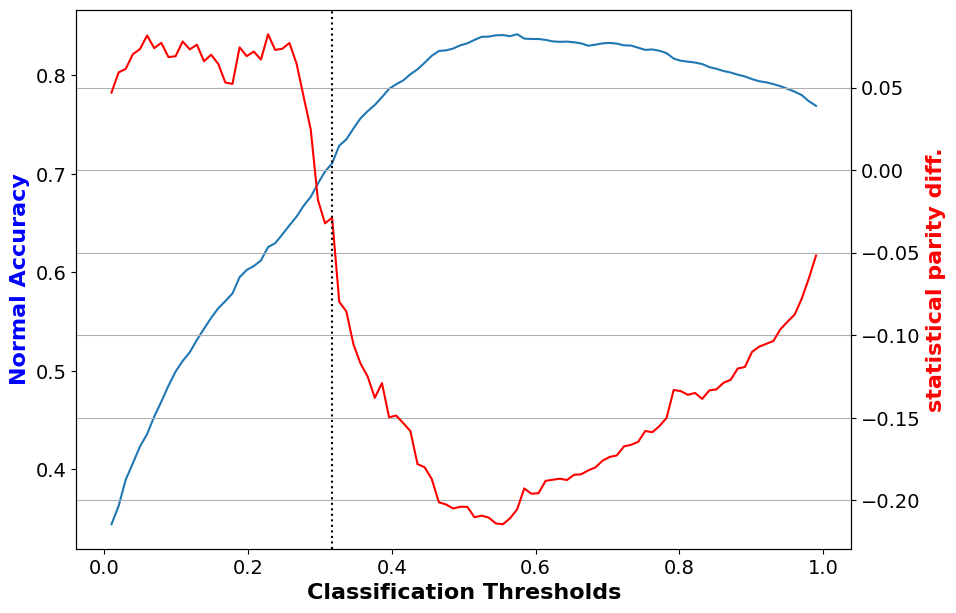

In [72]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Normal Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_parity_diff_tranf, color='r')
ax2.set_ylabel('statistical parity diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)